In [1]:
from collections import deque
from env.tsp_env import TspEnv
from utils import tsp_plots
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Set number of cities to visit
NUMBER_OF_CITIES = 10

In [3]:
MAXIMUM_RUNS = 20000
MAXIMUM_TIME_MINS = 180
NO_IMPROVEMENT_RUNS = 1000
NO_IMPROVEMENT_TIME = 180

In [4]:
# Discount rate of future rewards
GAMMA = 0.99
# Learing rate for neural network
LEARNING_RATE = 0.001
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 100000
# Number of training steps
BATCH_SIZE = 5
# Number of game steps to play before starting training
REPLAY_START_SIZE = 10000
# Exploration rate (episolon) is probability of choosign a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.001
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.995

In [5]:
class DQN(nn.Module):

    """
    Deep Q Network solver. Includes control variables, memory of 
    state/action/reward/end, neural net,and methods to act, 
    remember, and update neural net by sampling from memory.
    """
    
    def __init__(self, observation_space, n_actions):
        """Constructor method. Set up memory and neural nets."""
        
        self.n_actions = n_actions
        
        # Set starting exploration rate
        self.exploration_rate = EXPLORATION_MAX
        
        # Set up memory for state/action/reward/next_state/done
        # Deque will drop old data when full
        self.memory = deque(maxlen=MEMORY_SIZE)

        # Set up neural net
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, NUMBER_OF_CITIES * 5),
            nn.ReLU(),
            nn.Linear(NUMBER_OF_CITIES * 5, NUMBER_OF_CITIES * 5),
            nn.ReLU(),
            nn.Linear(NUMBER_OF_CITIES * 5, NUMBER_OF_CITIES * 5),
            nn.ReLU(),
            nn.Linear(NUMBER_OF_CITIES * 5, n_actions))
        
        # Set loss function and optimizer
        self.objective = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.net.parameters(), lr=LEARNING_RATE)
        
    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""
        
        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.n_actions)
            
        else:
            # Otherwise get predicted Q values of actions
            q_values = self.net(torch.FloatTensor(state))
            # Get index of action with best Q
            action = np.argmax(q_values.detach().numpy()[0])
        
        return  action
    
    
    def experience_replay(self, runs):
        """Update model by sampling (s/a/r/s') from memory. As the memory 
        accumulates knowledge of rewards, this will lead to a better ability to
        estimate Q (which depends on future possible rewards."""
        
                    
        # Do not try to train model if memory is less than reqired batch size
        if len(self.memory) < BATCH_SIZE:
            return
        
        # Reduce exploration rate down to minimum
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
        
        # Sample a random batch from memory
        batch = random.sample(self.memory, BATCH_SIZE)
        
                
        for state, action, reward, state_next, terminal in batch:
            
            if terminal:
                q_update = reward

            else:
                # Get best possible Q for next action
                action_q = self.net(torch.FloatTensor(state_next))
                action_q = action_q.detach().numpy().flatten()
                best_next_q = np.amax(action_q)
                # Calculate current Q using Bellman equation
                q_update = (reward + GAMMA * best_next_q)
                
            # Get predicted Q values for current state
            q_values = self.net(torch.FloatTensor(state))

            # Update predicted Q for current state/action
            q_values[0][action] = q_update
            
            # Update neural net to better predict the updated Q value
            
            # Reset net gradients
            self.optimizer.zero_grad()  
            # calculate loss
            loss_v = nn.MSELoss()(self.net(torch.FloatTensor(state)), q_values)
            # Backpropogate loss
            loss_v.backward()
            # Update network gradients
            self.optimizer.step()

            
    def forward(self, x):
        """Feed forward function for neural net"""
        
        return self.net(x)
    
    
    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        
        self.memory.append((state, action, reward, next_state, done))

In [6]:
def main():
    """Main program loop"""
    
    # Set up environment
    time_start = time.time()
    env = TspEnv(number_of_cities = NUMBER_OF_CITIES)
    
    # Get number of observations returned for state
    observation_space = env.observation_space.shape[0] * 2
    
    # Get number of actions possible
    n_actions = len(env.action_space)
    
    # Set up neural net
    dqn = DQN(observation_space, n_actions)   
    
    # Set up list for results
    results_run = []
    results_exploration = []
    total_rewards = []
    best_reward = -999999
    best_route = None
    
    # Set run and time of last best route
    run_last_best = 0
    time_last_best = time.time()

    # Set up run counter and learning loop
    step = 0
    run = 0
    continue_learning = True
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        # Increment run (episode) counter
        run += 1
        total_reward = 0
        
        # Start run and get first state observations
        state, reward, terminal, info = env.reset()
        total_reward += reward
        
        # Reshape state into 2D array with state obsverations as first 'row'
        state = np.reshape(state, [1, observation_space])
        
        # Reset route
        route = []
        
        # Continue loop until episode complete
        while True:
            
            # Increment step counter
            step += 1
            
            # Get action to take
            action = dqn.act(state)
            route.append(action)
            
            # Act
            state_next, reward, terminal, info = env.step(action)
            total_reward += reward
                     
            # Get observations for new state (s')
            state_next = np.reshape(state_next, [1, observation_space])
                        
            # Record state, action, reward, new state & terminal
            dqn.remember(state, action, reward, state_next, terminal)
            
            # Update state
            state = state_next
            
            # Update neural net
            if len(dqn.memory) >= REPLAY_START_SIZE:
                dqn.experience_replay(run)  
        
                 
            # Actions to take if end of game episode
            if terminal:
                # Clear print row content
                clear_row = '\r' + ' '*100 + '\r'
                print (clear_row, end ='')
                print (f'Run: {run: 5.0f}, ', end='')
                print (f'exploration: {dqn.exploration_rate: 4.3f}, ', end='')
                print (f'reward: {total_reward: 6.0f}', end='')
                
                # Add to results lists
                results_run.append(run)
                results_exploration.append(dqn.exploration_rate)
                total_rewards.append(total_reward)                

                # Check for best route so far
                if total_reward > best_reward:
                    best_reward = total_reward
                    best_route = route
                    run_last_best = run
                    time_last_best = time.time()
                    time_elapsed = (time.time() - time_start) / 60
                    print(f'\nNew best run. Run : {run: 5.0f},  ' \
                          f'Time {time_elapsed: 4.0f}  ' \
                          f'Reward {total_reward: 6.0f}')                
                                            
                # Check stopping conditions
                stop = False
                if step > REPLAY_START_SIZE:
                    if run == MAXIMUM_RUNS:
                        stop = True
                    elif time.time() - time_start > MAXIMUM_TIME_MINS * 60:
                        stop = True
                    elif time.time() - time_last_best > NO_IMPROVEMENT_TIME*60:
                        stop = True
                    elif run - run_last_best == NO_IMPROVEMENT_RUNS:
                        stop = True
                        
                if stop:
                    # End training
                    continue_learning = False
     
                # End episode
                break
            
    ############################# Plot results #################################
        
    # Plot result progress
    tsp_plots.plot_result_progress(total_rewards)

    # Plot best route
    tsp_plots.plot_route(env, best_route)
    
    ###################### Show route and distances ############################
    
    print ('Route')
    print (best_route)
    print ()
    print ('Best route distance')
    print (f'{env.state.calculate_distance(best_route):.0f}')

Run:     1, exploration:  1.000, reward:  -7699                                                     
New best run. Run :     1,  Time    0  Reward  -7699
Run:     2, exploration:  1.000, reward:  -3463                                                     
New best run. Run :     2,  Time    0  Reward  -3463
Run:     4, exploration:  1.000, reward:  -1607                                                     
New best run. Run :     4,  Time    0  Reward  -1607
Run:    10, exploration:  1.000, reward:  -1393                                                     
New best run. Run :    10,  Time    0  Reward  -1393
Run:    50, exploration:  1.000, reward:  -1253                                                     
New best run. Run :    50,  Time    0  Reward  -1253
Run:   113, exploration:  1.000, reward:    333                                                     reward:  -5362
New best run. Run :   113,  Time    0  Reward    333
Run:   919, exploration:  0.001, reward:    555               

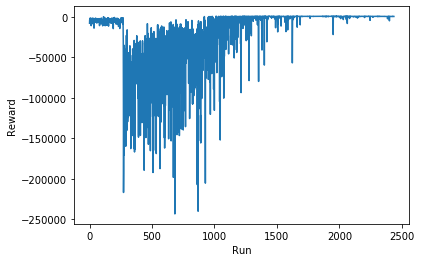

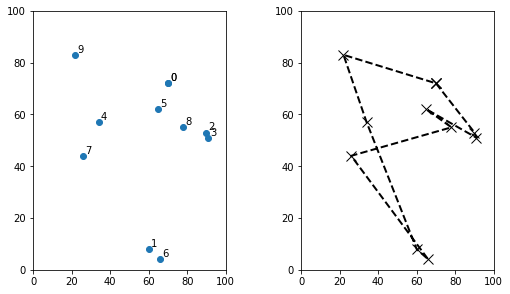

Route
[2, 3, 5, 8, 7, 6, 1, 4, 9, 0]

Best route distance
296


In [7]:
main()